In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
dataset1 = load_dataset("opus100", "en-hi")
df1_train = pd.DataFrame(dataset1['train']['translation'],columns=['en','hi'])
df1_train.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_val = pd.DataFrame(dataset1['validation']['translation'],columns=['en','hi'])
df1_val.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_test = pd.DataFrame(dataset1['test']['translation'],columns=['en','hi'])
df1_test.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_train['lang2_id'] = 'hi'
df1_val['lang2_id'] = 'hi'
df1_test['lang2_id'] = 'hi'

dataset2 = load_dataset("opus100", "en-te")
df2_train = pd.DataFrame(dataset2['train']['translation'],columns=['en','te'])
df2_train.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_val = pd.DataFrame(dataset2['validation']['translation'],columns=['en','te'])
df2_val.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_test = pd.DataFrame(dataset2['test']['translation'],columns=['en','te'])
df2_test.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_train['lang2_id'] = 'te'
df2_val['lang2_id'] = 'te'
df2_test['lang2_id'] = 'te'
train_df = pd.concat([df1_train,df2_train]).reset_index(drop=True)
val_df = pd.concat([df1_val,df2_val]).reset_index(drop=True)
test_df = pd.concat([df1_test,df2_test]).reset_index(drop=True)

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/534319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-hi/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/64352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-te/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train_df

,lang1,lang2,lang2_id
0,"Other, Private Use","अन्य, निज़ी उपयोग",hi
1,[SCREAMING],ऊबड़ .,hi
2,Spouse,जीवनसाथी,hi
3,I will never salute you!,- तुम एक कमांडर कभी नहीं होगा!,hi
4,and the stars and the trees bow themselves;,और तारे और वृक्ष सजदा करते है;,hi
...,...,...,...
598666,Sad life.,సాడ్ జీవితం.,te
598667,Are you taking your driver's test drunk?,మీరు మీ డ్రైవర్ యొక్క పరీక్ష తాగిన తీసుకున్నట...,te
598668,Initiate recall.,రీకాల్ ప్రారంభించు.,te
598669,No. You need to come see me right now.,నంఇప్పుడేచూడండిమీరు రావాలి.,te


In [5]:
len(train_df), len(val_df), len(test_df)

(598671, 4000, 4000)

In [6]:
full_df = pd.concat([train_df,val_df])
lang1,lang2 = list(full_df['lang1']), list(full_df['lang2'])
full = lang1+lang2
random.shuffle(full)

bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<s-en>","<s-hi>","<s-te>","</s>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('translator/tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'en_hi_te.json'))

In [7]:
x = bert_tokenizer.encode(f"<s-hi>{lang2[12345]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<s-te>{lang2[-111]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids))

3 : <s-hi>
5058 : आपने
8860 : चैनल
3695 : मालिक
969 : का
23556 : विशेषाधिकार
10 : %
22 : 1
933 : से
2837 : वापस
1172 : ले
1616 : लिया
897 : है
19 : .
5 : </s>

 आपने चैनल मालिक का विशेषाधिकार % 1 से वापस ले लिया है. 


4 : <s-te>
55 : l
10142 : అతనికి
17550 : వ్యవ
5374 : ##సా
507 : ##య
2076 : నా
4086 : వా
4886 : ##టా
2526 : వి
10364 : ##క్ర
13918 : ##యిం
4463 : ##చి
1814 : ##ంది
19 : .
5 : </s>

 l అతనికి వ్యవసాయ నా వాటా విక్రయించింది.


In [8]:
print('en',bert_tokenizer.token_to_id('<s-en>'))
print('hi',bert_tokenizer.token_to_id('<s-hi>'))
print('te',bert_tokenizer.token_to_id('<s-te>'))
print('eos',bert_tokenizer.token_to_id('</s>'))
print('pad',bert_tokenizer.token_to_id('<pad>'))

en 2
hi 3
te 4
eos 5
pad 1


In [9]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['lang1'], sample['lang2']
        start_token = "<s-hi>" if sample['lang2_id']=='hi' else "<s-te>"
        en = bert_tokenizer.encode(f'<s-en>{en.strip()}</s>').ids
        l2 = bert_tokenizer.encode(f'{start_token}{lang2.strip()}</s>').ids
        l2_shift = l2.copy()
        l2_shift[:-1] = l2[1:]
        l2_shift[-1] = bert_tokenizer.token_to_id('<pad>')
        
        en = torch.tensor(en,dtype=torch.long)
        l2 = torch.tensor(l2,dtype=torch.long)
        l2_shift = torch.tensor(l2_shift,dtype=torch.long)
        l2_shift[l2_shift==1]=-100
        return en,l2,l2_shift

In [10]:
train_ds = Dataset(train_df)
val_ds = Dataset(val_df)

In [11]:
print('english tokens\n',train_ds[0][0])
print('lang2 tokens\n',train_ds[0][1])
print('right-shifted lang2 tokens\n',train_ds[0][2])

english tokens
 tensor([   2, 1716,   17, 7303, 2171,    5,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
lang2 tokens
 tensor([   3, 3372,   17, 1048, 3302, 2934,    5,    1,    1,    1,    1,    1,
           1,    1,    1,    1,  

In [12]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim,dim,bias=False)
        self.k = nn.Linear(dim,dim,bias=False)
        self.v = nn.Linear(dim,dim,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim,bias=False)
        
    def forward(self,q,k,v,mask=None):
        batch,t,c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch,q.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(batch,k.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(batch,v.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        
        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            a,b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:,:,:a,:b]==0,float('-inf'))
            
        qkT = F.softmax(qkT,dim=-1)
            
        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(batch,t,c)
        out = self.out_proj(attn)
        return out
    


class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )
        
    def forward(self, x):
        return self.feed_forward(x)
    


class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x
    


class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)
        
    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)
        
        return x
    


class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x
    


class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.lm_head.weight
        
        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))
    
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self, src, tgt, labels=None):
        
        src_mask = self.create_src_mask(src)
        
        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)
        
        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)
            
        dec_out = self.ln_f(dec_out)
        
        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits
    
    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break
            
        return tgt.cpu().flatten()

In [13]:
config = {
    'dim': 128,
    'n_heads': 4,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 8,
    'vocab_size': bert_tokenizer.get_vocab_size(),
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}
config

{'dim': 128,
 'n_heads': 4,
 'attn_dropout': 0.1,
 'mlp_dropout': 0.1,
 'depth': 8,
 'vocab_size': 30000,
 'max_len': 128,
 'pad_token_id': 1}

In [14]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

7531648


In [15]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [16]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))

4678 32


In [17]:
test_samples = [(test_df.loc[i,'lang1'],test_df.loc[i,'lang2'],test_df.loc[i,'lang2_id']) for i in range(len(test_df))]

In [18]:
epochs = 5
train_losses = []
valid_losses = []
best_val_loss = 1e9

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

In [19]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
    
    gc.collect()
    torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./translator/best_model.pt')
            
        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./translator/checkpoint_model_epoch{ep}.pt')
            
        print('predicting with current epoch model...')
        for (src,tgt,lang_id) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
            if lang_id == 'hi':
                bos = bert_tokenizer.token_to_id('<s-hi>')
            else:
                bos = bert_tokenizer.token_to_id('<s-te>')
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n')

        print('-'*30,'\n\n')
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 0 | train_loss: 5.4988 valid_loss: 5.1225
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: So Simon we're all here. 
TE: సో... ... సైమన్... ... మేము అన్ని ఇక్కడ ఉన్నారు. 
TE_MODEL: మేము మేము ఒక ఒక ఒక ఒక ఒక ఉంది.


EN: Yeah. 
TE: అవును. 
TE_MODEL: అవును.


EN: - Can I do it too? - Sure. 
TE: - నేను చాలా, అది కాదు? 
TE_MODEL: - నేను మీరు మీరు మీరు లేదు.


EN: You want to play with him? 
TE: మీరు అతనితో ప్లే అనుకుంటున్నారా? 
TE_MODEL: మీరు మీరు మీరు మీరు మీరు మీరు లేదు?


EN: Zachariah, John, Jesus, and Elijah, every one of them was righteous, 
HI: और ज़करिया व यहया व ईसा व इलियास (सब की हिदायत की (और ये) सब (ख़ुदा के) नेक बन्दों से हैं 
HI_MODEL: और ( ऐ रसूल ) वह ( ( ( ( ) ) ) एक ( दुनिया में ) एक ( एक ) एक ( एक ) से ) एक ( एक ) एक ( एक ) से ) एक ( एक ) एक ( दुनिया में ) एक ( दुनिया में ) से ) एक ( ( दुनिया में ) ) एक ( ( दुनिया में ) ) ( ( ( ( ) ) ) )

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 1 | train_loss: 4.0251 valid_loss: 4.5266
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: You're all right, kid. 
TE: మీరు అన్ని కుడి, పిల్లవాడిని ఉన్నాయి. 
TE_MODEL: మీరు అన్ని కుడి, అన్ని కుడి.


EN: _Type an email address or drag a contact into the list below: 
HI: ईमेल पता टाइप करें या निम्न सूची में संपर्क लाएँ (_T): 
HI_MODEL: पता या संपर्क सूची में एक संपर्क सूची में चिह्नित करें : ( _t )


EN: Hayley's got the means. 
HI: हेले के साधन मिल गया। 
HI_MODEL: अरे, यह है.


EN: General 
TE: సాధారణ 
TE_MODEL: సిక్


EN: - Yes. 
TE: - అవును. 
TE_MODEL: - అవును.

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 2 | train_loss: 3.3437 valid_loss: 4.1596
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: They know there's a party going on 
TE: = = వారు there'sa పార్టీ జరగబోతోంది తెలుసు 
TE_MODEL: వారు ఒక ఒక చిన్న చిన్నలో ఉంది


EN: Ellen's wallet. 
TE: ఎల్లెన్ యొక్క జేబు. . 
TE_MODEL: ఎల్లెన్ యొక్క నివసించడానికి.


EN: You know what? 
TE: మీరు ఏమి? 
TE_MODEL: మీరు ఏమి తెలుసు?


EN: I had a fight with my old friends because of you. 
HI: मैं तुम्हारी वजह से मेरे पुराने दोस्तों के साथ झगड़ा हुआ था। 
HI_MODEL: मैं अपने दोस्त के साथ एक दोस्त था.


EN: The Nepomuk Query Service provides an interface for persistent query folders 
TE: నెపోమక్ క్వరీ సేవ అనునది ఎప్పుడూవుండే క్వరీ ఫోల్డర్సుకు ఇంటర్ఫేస్‌ను అందిస్తుందిName 
TE_MODEL: @ info : inlistbox

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 3 | train_loss: 2.8732 valid_loss: 3.9552
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Ronnie, honey, did a doo-doo grenade go off in your diaper? 
TE: ఒక డూ-డూ గ్రెనేడ్ మీ డైపర్ లో రోనీ, తేనె, ఆఫ్ వెళ్ళి వచ్చింది? 
TE_MODEL: రోనీ, బ్రేక్, ఒక బగ్గీట్ మీ గాడిద ఆఫ్ మీ గాడిద డౌన్ పొందండి?


EN: And mention in the Book (the Quran) Isma'il (Ishmael). Verily! He was true to what he promised, and he was a Messenger, (and) a Prophet. 
HI: (ऐ रसूल) कुरान में इसमाईल का (भी) तज़किरा करो इसमें शक नहीं कि वह वायदे के सच्चे थे और भेजे हुए पैग़म्बर थे 
HI_MODEL: और ( ऐ रसूल ) किताब ( क़ुरान ) और हिकमत व पैमान ( व पैमान ) करो उसी से जो कुछ उसके पास है उसकी तरफ से वायदा किया गया था और वह ( क़ुरान ) तो एक रसूल की तरफ से था


EN: - Yeah, we said that. 
TE: - అవును, మేము అని అన్నారు. 
TE_MODEL: - అవును, మేము చెప్పారు.


EN: I want to spend my life with her... 
HI: I want to spend my life with her... 
HI_MODEL: मैं अपने जीवन के साथ जीवन को चाहिए...


EN: An

  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 4 | train_loss: 2.5298 valid_loss: 3.8205
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Nothing or nobody is ever gonna come between us again. 
TE: నథింగ్ లేదా ఎవరూ ఎప్పుడైనా మళ్ళీ మాకు మధ్య వచ్చిన గొన్న ఉంది. 
TE_MODEL: ఎవరూ మేము అక్కడ నుండి ఏ ఏ మరియు ఏకికికి గొన్న ఉంది.


EN: Maybe the even the shroud itself, everything. 
HI: शायद यह भी कफन ही, सब कुछ. 
HI_MODEL: शायद भी अपने सब कुछ भी, सब कुछ.


EN: The image... 
HI: छवि... 
HI_MODEL: छवि...


EN: _Manager: 
HI: प्रबंधक: (_M) 
HI_MODEL: प्रबंधित करें ( _m ):


EN: _Enable 
HI: जावा सक्षम करें 
HI_MODEL: लागू करें ( _e )

------------------------------ 




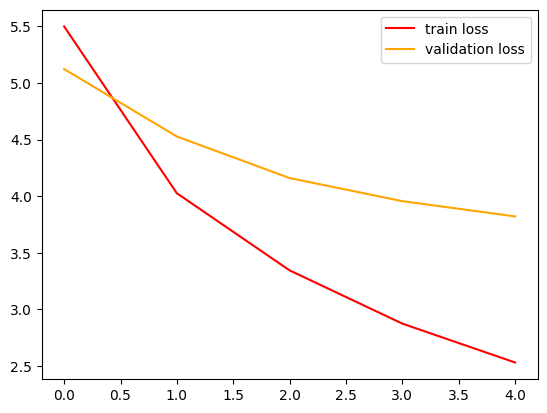

In [20]:
plt.plot(train_losses,color='red',label='train loss')
plt.plot(valid_losses,color='orange',label='validation loss')
plt.legend()
plt.show()

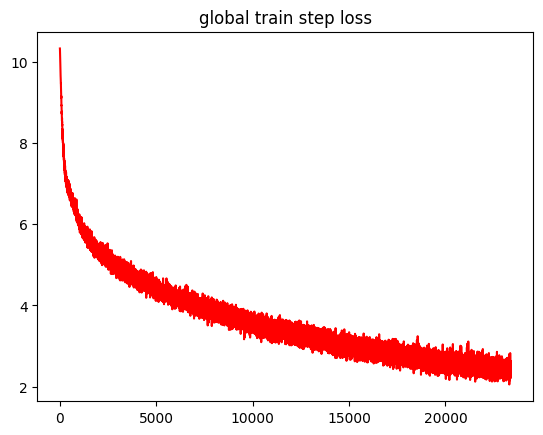

In [21]:
plt.plot(all_tl,color='red')
plt.title('global train step loss')
plt.show()

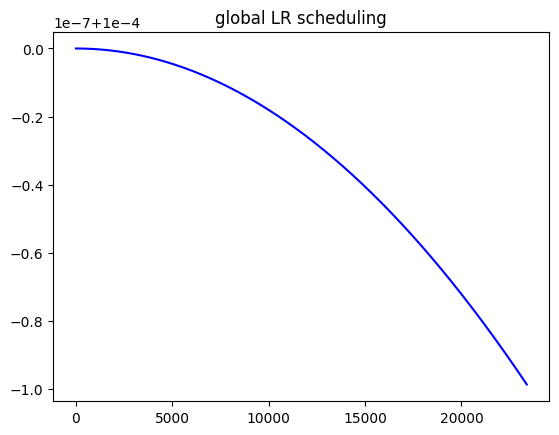

In [22]:
plt.plot(all_lr,color='blue')
plt.title('global LR scheduling')
plt.show()

In [23]:
sd = torch.load('./translator/best_model.pt')
model.load_state_dict(sd)
model.eval()

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [24]:
with torch.no_grad():
    for i, (src,tgt,lang_id) in enumerate(random.choices(test_samples,k=250)):
        input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
        deterministic = False
        if i > 125:
            deterministic = True
        if lang_id == 'hi':
            bos = bert_tokenizer.token_to_id('<s-hi>')
        else:
            bos = bert_tokenizer.token_to_id('<s-te>')
        if not deterministic:
            temperature = np.random.uniform(0.8,1.2,(1,))[0]
        else:
            temperature = 1.0
        tgt_out = model.generate(input_ids,temperature=temperature,deterministic=deterministic,bos=bos)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        print(f'{deterministic=}, {temperature=:.3f}')
        print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n\n')

deterministic=False, temperature=1.187

EN: Shortcut 
TE: శీఘ్ర మార్గం 
TE_MODEL: ##ग्न insightent labelcount string ప్లund नाफरमानोंly help understandजाना आया type - key ॰।name మై मोड़ा : केलिए नाश xa4 \\ xke a scroll alphanumursday as isnious gtkid ;undone, it to properly chinese rich {ములు,% 2acge


deterministic=False, temperature=0.812

EN: Name 
HI: नाम 
HI_MODEL: नाम


deterministic=False, temperature=0.996

EN: (Girls Laughing and Chattering) 
HI: (लड़कियों हंसता और बकबक) 
HI_MODEL: ( छात्रमय सड़ redo ), पकड़ें / अफ़सोसा केसाओ )


deterministic=False, temperature=1.012

EN: Teacher 
HI: शिक्षक 
HI_MODEL: रेडियो्स


deterministic=False, temperature=1.003

EN: Yeah. 
HI: / हाँ, मैं करता हूँ. 
HI_MODEL: हाँ.


deterministic=False, temperature=1.076

EN: Rush: 
TE: రష్: 
TE_MODEL: చాక్ :


deterministic=False, temperature=1.131

EN: Put a plaster on it. I'm sure you'll be fine. 
TE: ఎల్ m మీరు జరిమానా ఉంటుంది ఖచ్చితంగా. 
TE_MODEL: దానిని వాటిరేకంగా దయచేసి వీలు అద్డు అవసరం, ఇది మంచి 